In [1]:
import numpy as np
import xarray as xr
import pickle
from hyperopt import fmin, hp, Trials, STATUS_OK
from hyperopt import atpe
import minisom
from pathlib import Path
import sys
parent = Path.cwd().parent.resolve()
sys.path.insert(0, str(parent))
from importlib import reload
import SOM_functions as functions
reload(functions)
import warnings
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment
from sklearn.utils import resample
from scipy.stats import theilslopes, kendalltau
import glob
import os
import cftime
np.warnings = warnings
import pandas as pd
from sklearn.utils import resample
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib.lines import Line2D
import pymannkendall as mk
import matplotlib as mpl

/home/users/tildah/nb_envs/SOM_env/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
ERA5 = xr.open_dataset('node_assignments/ERA5_node_assignments.nc')
model = xr.open_dataset('node_assignments/CanESM5_hist-GHG_node_assignments.nc')
#print(model)
#em_1_mask = model['member'] == 1
#print(model.where(em_1_mask, drop=True))

In [3]:
ERA5 = xr.open_dataset('node_assignments/ERA5_node_assignments.nc')
model = xr.open_dataset('node_assignments/CanESM5_hist-GHG_node_assignments.nc')
model2 = xr.open_dataset('node_assignments_compare_to_ERA5/CanESM5_hist-GHG_node_assignments.nc')
print(model['best_node_idx'].values[:20])
print(model['best_node_corr'].values[:20])
print(model2['best_node_idx'].values[:20])
print(model2['best_node_corr'].values[:20])
#em_1_mask = model['member'] == 1
#print(model.where(em_1_mask, drop=True))

[3 3 3 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[0.43896016 0.3701903  0.35670418 0.38573533 0.43121994 0.34384885
 0.16863668 0.13833968 0.2972196  0.38349354 0.35513926 0.4198621
 0.52666944 0.5247887  0.504998   0.5102867  0.51479995 0.5370125
 0.43760654 0.28463072]
[3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0]
[0.54945767 0.5127387  0.5161683  0.52966523 0.45808077 0.29060233
 0.14946385 0.15581708 0.29295835 0.4246205  0.439706   0.51358163
 0.6087884  0.64726067 0.6846784  0.69412506 0.6762687  0.694381
 0.64287    0.53402865]


/tmp/ipykernel_10952/3094136521.py:268: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


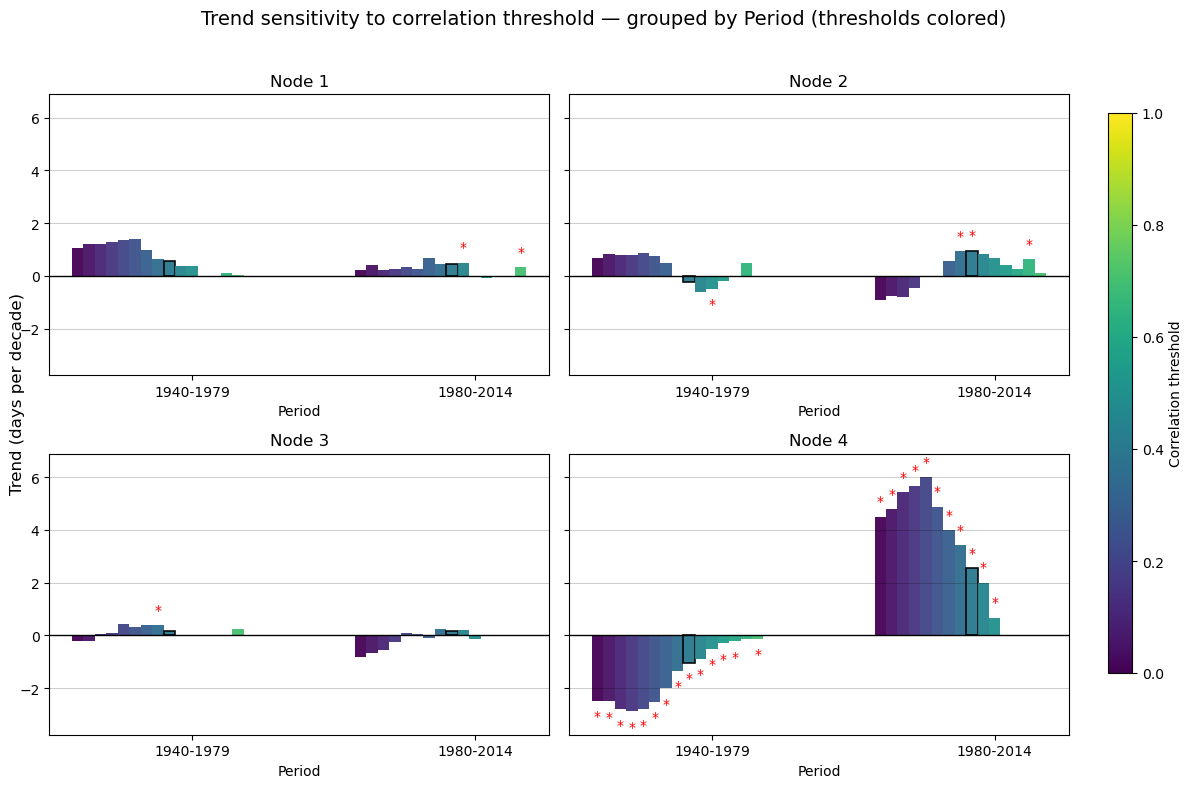

In [5]:


# -------------------- user-changeable params --------------------
nc_path = "node_assignments/ERA5_node_assignments.nc"
mk_available = True

# choose mode: "corr" uses best_node_corr and best_node_idx (thresholds in [0,1])
#             "euc"  uses best_node_dist_euc and best_node_idx_euc (thresholds interpreted as percentiles 0..100)
mode = "corr" #"corr" or "euc"
window = 5            # smoothing window (years) used when computing annual counts
if mode == "corr":
    thr_start = 0.0
    thr_stop  = 1.0
    thr_step  = 0.05
else:
    thr_start = 0.0
    thr_stop  = 100
    thr_step  = 5
periods = {
    "1940-1979": (1940, 1979),
    "1980-2014": (1980, 2014)
}
period_names = list(periods.keys())
# if you *still* want a custom plotting node order, set node_order; otherwise leave None to use available nodes
node_order = None    # e.g. [2,3,1,0] or None to use order from data
# ----------------------------------------------------------------

# load dataset
ds = xr.open_dataset(nc_path)

# extract arrays
time = ds["time"].values                        # np.datetime64 array
time_index = pd.to_datetime(time)
best_node_idx = ds["best_node_idx"].values      # int with possibly fill values
best_node_corr = ds["best_node_corr"].values    # correlation floats
best_node_idx_euc = ds["best_node_idx_euc"].values.astype(float)      # cast float to allow np.nan
best_node_dist_euc = ds["best_node_dist_euc"].values.astype(float)

# some datasets store integer missing values (e.g. -1). Convert to NaN where correlation is NaN or idx invalid
# we'll use corr to mask anyway, but ensure idx dtype is float so we can place np.nan
best_node_idx = best_node_idx.astype(float)
# if corr contains NaNs this will propagate below when applying thresholds

# time_array for DataFrame
time_array = pd.to_datetime(time)

# span thresholds
if mode == "corr":
    # thresholds interpreted as correlation values (0..1)
    thresholds = np.arange(thr_start, thr_stop + 1e-9, thr_step)
    threshold_label = "Correlation threshold"
else:
    # mode == "euc": thresholds interpreted as percentiles (0..100)
    thresholds = np.arange(thr_start, thr_stop + 1e-9, thr_step)  # e.g. 0..100
    threshold_label = "Distance percentile threshold (0-100)"

# precompute percentiles->distance mapping only in euc mode for speed
if mode == "euc":
    # compute unique percentiles we will evaluate (in case thresholds repeated)
    percentiles_to_eval = np.unique(thresholds)
    # For robustness, ignore NaNs in distance array when computing percentiles
    p_to_d = { p: np.nanpercentile(best_node_dist_euc, p) for p in percentiles_to_eval }

# find node list from data (unique, preserving appearance order)
# preserve order of first appearance in best_node_idx (ignoring nans)
valid_idx_mask = np.isfinite(best_node_idx)
unique_nodes = []
for val in best_node_idx[valid_idx_mask].astype(int):
    if val not in unique_nodes:
        unique_nodes.append(int(val))
nodes = np.array(unique_nodes, dtype=int)

if node_order is not None:
    # ensure node_order includes all nodes present (add missing ones at end)
    node_order = list(node_order)
    for n in nodes:
        if n not in node_order:
            node_order.append(int(n))
else:
    node_order = list(nodes)

# prepare results structure
results = { node: { pname: {"slope": [], "sig": []} for pname in period_names } for node in node_order }

# iterate thresholds
for thr in thresholds:
    # apply threshold: keep node assignment only if corr >= thr
    if mode == "corr":
        # use correlation arrays and original node idx
        score_array = best_node_corr
        node_idx_array = best_node_idx
        # keep when correlation >= threshold
        mask_keep = (score_array >= thr) & np.isfinite(node_idx_array)
    else:
        # euc mode: interpret thr as percentile -> lookup distance cutoff and keep distances <= cutoff
        cutoff = p_to_d[thr]
        score_array = best_node_dist_euc
        node_idx_array = best_node_idx_euc
        mask_keep = (score_array <= cutoff) & np.isfinite(node_idx_array)
    # build dataframe
    df = pd.DataFrame({
        "time": time_array,
        "best_node": np.where(mask_keep, node_idx_array, np.nan),
        "score": np.where(mask_keep, score_array, np.nan)
    })
    # drop NaN node assignments
    df_valid = df.dropna(subset=["best_node"]).copy()
    if df_valid.empty:
        # append placeholders
        for node in node_order:
            for pname in period_names:
                results[node][pname]["slope"].append(np.nan)
                results[node][pname]["sig"].append(False)
        continue

    # cast node back to int for grouping
    df_valid["best_node"] = df_valid["best_node"].astype(int)
    df_valid["year"] = df_valid["time"].dt.year

    # count days per node per year
    annual_counts = df_valid.groupby(["year", "best_node"]).size().unstack(fill_value=0)

    # ensure all requested nodes are present as columns
    for n in node_order:
        if n not in annual_counts.columns:
            annual_counts[n] = 0
    # order columns according to node_order
    annual_counts = annual_counts[node_order].sort_index(axis=1)

    # smoothing (rolling mean over years)
    annual_counts_smoothed = annual_counts.rolling(window=window, center=True, min_periods=1).mean()

    # compute trends for each node and period
    for node in node_order:
        for period_name, (start_year, end_year) in periods.items():
            # select years in period
            sel = annual_counts_smoothed.loc[(annual_counts_smoothed.index >= start_year) &
                                            (annual_counts_smoothed.index <= end_year), node]
            y = sel.values
            x = sel.index.values.astype(float)   # years as floats

            if len(y) >= 3 and np.all(np.isfinite(y)):
                # theilslopes expects (y, x) or (y,) where x is implicit. Pass both to be explicit.
                try:
                    slope, intercept, lo_slope, hi_slope = theilslopes(y, x, 0.95)
                except Exception:
                    # fallback: try without x (shouldn't normally be needed)
                    slope, intercept, lo_slope, hi_slope = theilslopes(y)
                slope_decade = slope * 10.0  # convert per-year to per-decade

                # Mann-Kendall significance check
                sig = False
                try:
                    if mk_available:
                        
                        mk_result = mk.original_test(y)
                        sig = (mk_result.p < 0.05)
                    else:
                        # fallback using Kendall's tau on (time index, y)
                        # kendalltau returns pvalue; use two-sided test
                        tau_res = kendalltau(x, y, nan_policy="omit")
                        p = tau_res.pvalue if tau_res.pvalue is not None else 1.0
                        sig = (p < 0.05)
                except Exception:
                    sig = False
            else:
                slope_decade = np.nan
                sig = False

            results[node][period_name]["slope"].append(slope_decade)
            results[node][period_name]["sig"].append(bool(sig))


# -------------------- prepare plotting --------------------
# collect all slopes to set ylim
all_slopes = []
for node in node_order:
    for pname in period_names:
        all_slopes.extend(results[node][pname]["slope"])
all_slopes = np.array([v for v in all_slopes if (v is not None and not np.isnan(v))], dtype=float)

if all_slopes.size == 0:
    global_ymin, global_ymax = -1.0, 1.0
else:
    global_ymin = all_slopes.min()
    global_ymax = all_slopes.max()
    pad = max(0.1 * (global_ymax - global_ymin), 0.2)
    global_ymin -= pad
    global_ymax += pad

# colormap and normalizer
cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# figure layout: create a grid sized to number of nodes (choose 2x2 for up to 4 nodes, otherwise auto)
n_nodes = len(node_order)
ncols = 2
nrows = int(np.ceil(n_nodes / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), sharey=True)
if n_nodes == 1:
    axes = np.array([axes])
axes = axes.flatten()
axes = axes[:len(node_order)]

total_width = 0.85
n_thresh = len(thresholds)
width = total_width / n_thresh
offsets = (np.arange(n_thresh) - (n_thresh - 1) / 2.0) * width
x = np.arange(len(period_names))

for ax_idx, node in enumerate(sorted(node_order)):
    if ax_idx >= len(axes):
        break
    ax = axes[ax_idx]
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax.grid(axis='y', color='black', linestyle='-', linewidth=0.7, alpha=0.2)

    for k, thr in enumerate(thresholds):
        color = cmap(norm(thr))
        xpos = x + offsets[k]
        slopes_k = [results[node][pname]["slope"][k] for pname in period_names]
        sigs_k = [results[node][pname]["sig"][k] for pname in period_names]
        slopes_k = np.array(slopes_k, dtype=float)

        bars = ax.bar(xpos, slopes_k, width=width, color=color, edgecolor='none', alpha=0.95)

        # optionally emphasize a particular threshold (example 0.4)
        edge_col = 'black' if np.isclose(thr, 0.4) else 'none'
        lw = 1.2 if np.isclose(thr, 0.4) else 0.0
        if edge_col != 'none':
            for bar in bars:
                bar.set_edgecolor(edge_col)
                bar.set_linewidth(lw)

        # annotate significance
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if np.isnan(height):
                continue
            if sigs_k[j]:
                if height >= 0:
                    txt_y = height + 0.03 * (global_ymax - global_ymin)
                    va = "bottom"
                else:
                    txt_y = height - 0.03 * (global_ymax - global_ymin)
                    va = "top"
                ax.text(bar.get_x() + bar.get_width()/2, txt_y, "*", ha="center", va=va, color="red", fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(period_names, rotation=0)
    ax.set_xlabel("Period")
    ax.set_title(f"Node {node + 1}")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylim(global_ymin, global_ymax)

# hide unused axes
for i in range(n_nodes, len(axes)):
    axes[i].set_visible(False)

fig.text(0.005, 0.5, "Trend (days per decade)", va='center', rotation='vertical', fontsize=12)

# colorbar on right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(threshold_label)

plt.suptitle("Trend sensitivity to correlation threshold — grouped by Period (thresholds colored)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()


In [5]:
def compute_member_trends_corr(ds, model, exp,
                               threshold=0.4,
                               window=5, #for smoothing
                               alpha=0.05, #significance threshold
                               member_dim_name='member'):
    """
    Compute Theil-Sen slopes and significance per ensemble member, per node, per period
    using the correlation-based assignment (best_node_corr & best_node_idx).

    """
    periods = {"1940-1979": (1940, 1979), "1980-2014": (1980, 2014)}

    # Helper to compute for one member given 1D arrays
    def _compute_for_member(time_arr, idx_arr, corr_arr, member_id):
        # Ensure types
        time_pd = pd.to_datetime(time_arr)
        df_time = pd.DataFrame({"time": time_pd, "idx": idx_arr, "corr": corr_arr})
        df_time["year"] = df_time["time"].dt.year

        # apply threshold: keep rows where corr >= threshold and idx finite
        df_time["keep"] = (df_time["corr"] >= threshold) & np.isfinite(df_time["idx"])
        # set idx to NaN where not kept
        df_time.loc[~df_time["keep"], "idx"] = np.nan

        # group counts per year & node
        df_valid = df_time.dropna(subset=["idx"]).copy()
        if df_valid.empty:
            return []  # nothing for this member

        df_valid["node"] = df_valid["idx"].astype(int)
        annual_counts = df_valid.groupby(["year", "node"]).size().unstack(fill_value=0)

        # ensure contiguous year index sorted
        annual_counts = annual_counts.sort_index(axis=0)

        # smooth with centered rolling mean over years
        annual_counts_smoothed = annual_counts.rolling(window=window, center=True, min_periods=1).mean()

        out_rows = []
        for node in annual_counts_smoothed.columns:
            series_all_years = annual_counts_smoothed[node]
            for pname, (y0, y1) in periods.items():
                sel = series_all_years.loc[(series_all_years.index >= y0) & (series_all_years.index <= y1)]
                x_years = sel.index.values.astype(float)
                y_vals = sel.values

                n_years = int(np.sum(np.isfinite(y_vals)))
                if n_years >= 3 and np.all(np.isfinite(y_vals)):
                    # Theil-Sen slope (per year) -> convert to days/decade
                    try:
                        slope, intercept, lo_s, hi_s = theilslopes(y_vals, x_years, 0.95)
                    except Exception:
                        slope, intercept, lo_s, hi_s = theilslopes(y_vals)
                    slope_decade = slope * 10.0

                    # Mann-Kendall or Kendall tau fallback
                    pval = None
                    sig = False
                    try:
                        res = mk.original_test(y_vals)
                        pval = float(res.p)
                        sig = (pval < alpha)
                    except Exception:
                        pval = np.nan
                        sig = False
                else:
                    slope_decade = np.nan
                    pval = np.nan
                    sig = False

                out_rows.append({
                    "model": model,
                    "experiment": exp,
                    "member": int(member_id),
                    "node": int(node),
                    "period": pname,
                    "slope_days_per_decade": slope_decade,
                    "p_value": pval,
                    "significant": bool(sig)
                })
        return out_rows

    all_rows = []

    if member_dim_name == None:
        time_arr = ds["time"].values
        idx_arr = ds["best_node_idx"].values
        corr_arr = ds["best_node_corr"].values
        rows = _compute_for_member(time_arr, idx_arr, corr_arr, "1")
        all_rows.extend(rows)
    else:  
        member_vals = np.unique(ds[member_dim_name].values.astype(int))
        for m_val in member_vals:
            mask = (ds[member_dim_name].values.astype(int) == int(m_val))
            if not np.any(mask):
                continue
            time_arr = ds["time"].values[mask]
            idx_arr = ds["best_node_idx"].values.astype(float)[mask]
            corr_arr = ds["best_node_corr"].values.astype(float)[mask]
            rows = _compute_for_member(time_arr, idx_arr, corr_arr, m_val)
            all_rows.extend(rows)

    # convert to DataFrame
    df_out = pd.DataFrame(all_rows)
    df_out = df_out[["model", "experiment", "member","node","period","slope_days_per_decade","p_value","significant"]]
    return df_out


models = ['NorESM2-LM','CanESM5', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'MIROC6']
experiments = ['historical', 'hist-GHG', 'hist-aer']
all_trends = [] 

thresh = 0.7
for exp in experiments:
    for model in models:
        nc_path = f"node_assignments_compare_to_ERA5/{model}_{exp}_node_assignments.nc"
        ds = xr.open_dataset(nc_path)
        print(model, exp)
        df_trends = compute_member_trends_corr(ds, model, exp,
                                       threshold=thresh,
                                       window=5,
                                       alpha=0.05,
                                       member_dim_name='member')
        all_trends.append(df_trends)

nc_path = "node_assignments/ERA5_node_assignments.nc"
ERA5_ds = xr.open_dataset(nc_path)
ERA5_trends = compute_member_trends_corr(ERA5_ds, 'ERA5', 'ERA5',
                                       threshold=thresh,
                                       window=5,
                                       alpha=0.05,
                                       member_dim_name=None)
all_trends.append(ERA5_trends)
df_all = pd.concat(all_trends, ignore_index=True)
print(df_all)
output_path = f"All_models_threshold_{thresh}_ERA5comp.csv"
df_all.to_csv(output_path, index=False)


NorESM2-LM historical
CanESM5 historical
MPI-ESM1-2-LR historical
HadGEM3-GC31-LL historical
MIROC6 historical
NorESM2-LM hist-GHG
CanESM5 hist-GHG
MPI-ESM1-2-LR hist-GHG
HadGEM3-GC31-LL hist-GHG
MIROC6 hist-GHG
NorESM2-LM hist-aer
CanESM5 hist-aer
MPI-ESM1-2-LR hist-aer
HadGEM3-GC31-LL hist-aer
MIROC6 hist-aer
           model  experiment  member  node     period  slope_days_per_decade  \
0     NorESM2-LM  historical       1     0  1940-1979              -0.605556   
1     NorESM2-LM  historical       1     0  1980-2014               0.000000   
2     NorESM2-LM  historical       1     1  1940-1979               0.000000   
3     NorESM2-LM  historical       1     1  1980-2014              -0.443008   
4     NorESM2-LM  historical       1     3  1940-1979               0.156923   
...          ...         ...     ...   ...        ...                    ...   
2047        ERA5        ERA5       1     1  1980-2014               0.095238   
2048        ERA5        ERA5       1     2  194